# 计算香农熵
熵定义为信息的期望值（表示形式与数据期望相同，也可以看成一种数据期望），如果待分类的事物可能划分在多个分类之中，则符号$x_{i}$
$$l(x_{i}) = -log_{2}p(x_{i})$$其中$p(x_{i})$是选择分类的概率。为了计算熵，需要计算所有类别所有可能值包含的信息期望值，通过下面的公式得到：
$$H = -\sum ^n_{i=1}p(x_{i})log_{2}p(x_{i})$$

>　发现一个latex技巧，1个美刀符号之间的$latex$公式不会换行, 两个美刀符号之间的公式会在前后换行。

In [1]:
# 具体算法
from math import log

def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = dict()
    for fectVec in dataSet:
        currentLabel = fectVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt


In [2]:
def createDataSet():
    dataSet = [[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    return dataSet, labels

In [3]:
myDat, labels = createDataSet()
calcShannonEnt(myDat)

0.9709505944546686

In [4]:
myDat[0][-1] = 'maybe'
calcShannonEnt(myDat)

1.3709505944546687

# 划分数据集
分类算法除了需要测量信息熵，还需要划分数据集，度量划分数据集的熵，以便判断当前是否正确划分了数据集。
我们将对每个特征划分数据集的结果计算一次信息熵，然后判断按照哪个特征划分数据集是最好的划分方式。

In [5]:
def splitDataSet(dataSet, axis, value):  #　带划分的数据集、划分数据集的特征、需要返回的特征的值
    retDataSet = list()
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

# 选择最好的划分方式

算法原理：首先是计算有多少个特征，然后用该特征下属性分割数据集，计算每个子集的信息熵，然后通过:
$$Gain(D,a) = Ent(D) - \sum^{v}_{v=1}\frac{\left | D^{v} \right |}{\left | D \right |}Ent(D^{v})$$
计算分割后的信息熵，依次求得最小的信息熵记为最优特征。

In [6]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet) / float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy
        if(infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

In [7]:
myDat, labels = createDataSet()
print(chooseBestFeatureToSplit(myDat))

0


In [9]:
import operator

def majorityCnt(classList):
    classCount = dict()
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]


# 算法原理
求得最优特征之后，通过特征的属性划分后的子集中标签出现最多的情况即为该属性对应的结果。

In [62]:
# 创建树
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel: {}}
    del (labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree


In [63]:
def storeTree(inputTree, filename):   # 保存训练模型
    import pickle, json
    fw = open(filename, 'wb')
    pickle.dump(inputTree, fw)
    fw.close()

def grabTree(filename):  # 还原训练模型
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)

In [64]:
storeTree(result, "trainTree.dat")

# 运行决策树执行分类
决策树分类的原理就是在遍历子树，找到满足给定条件的结果。

In [71]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]  # 找到当前根节点的标签
    secondDict = inputTree[firstStr]  # 得到其子树
    featIndex = featLabels.index(firstStr)  # 从键判断当前是第几个特征
    key = testVec[featIndex]  # 找到测试数据该特征下的属性值
    valueOfFeat = secondDict[key]  #  从属性值找到符合要求的子树
    if isinstance(valueOfFeat, dict):  #如果结果是字典代表要在子树的基础上继续查找
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else:  #查询成功返回结果
        classLabel = valueOfFeat
    return classLabel

In [72]:
myDat, labels = createDataSet()
result = grabTree("trainTree.dat")
classify(result, labels, [1,1])

'yes'

# 使用决策树预测隐形眼镜


In [73]:
fr = open("lenses.txt")
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate' ]
lensesTree = createTree(lenses, lensesLabels)

In [74]:
lensesTree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

In [75]:
from treePlotter import createPlot

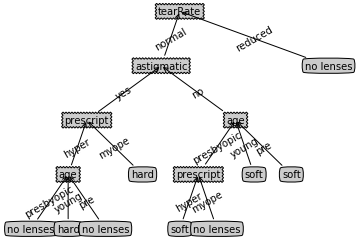

In [76]:
createPlot(lensesTree)

In [77]:
classify(lensesTree,  ['age', 'prescript', 'astigmatic', 'tearRate' ],['young'	,'myope'	,'no'	,'reduced'	,'no lenses'])

'no lenses'